<a href="https://colab.research.google.com/github/SkittyWitty/OceanTrashDetection/blob/main/OceanTrashDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.utils import img_to_array
import tensorflow as tf
import keras
import numpy as np
import os
import cv2
import fnmatch
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
# Location of data on google drive
DATASET_PATH = '/content/drive/MyDrive/Trash Detection/datasets_new/'

# This label mode is compatible with the spare categorical crossentrophy loss
LABEL_MODE = "int"

#Prepare Data
Images were resized, manipulated and saved prior to make the training process quicker. To view code for preparing the image data refer to the following notebook: https://colab.research.google.com/drive/19SVN7GSKh3CjjgbgSxFtcikWF-U_ETCC?usp=sharing


# Visualize Data
Understanding the data we have to work with. Classes we have. Number of samples per class. First peek into the images.

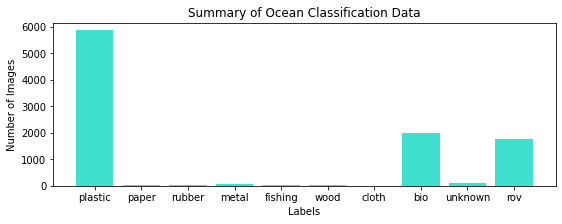

In [ ]:
label_counts = []
folder_names = []
total_count = 0
for folder in os.listdir(DATASET_PATH):
  count = len(fnmatch.filter(os.listdir(DATASET_PATH + folder + "/"), '*.*'))
  folder_names.append(folder)
  label_counts.append(count)
  total_count = total_count + count

plt.figure(figsize=(9, 3))
plt.title('Summary of Ocean Classification Data')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.bar(folder_names, label_counts, color="turquoise")
plt.show()

Found 9883 files belonging to 10 classes.


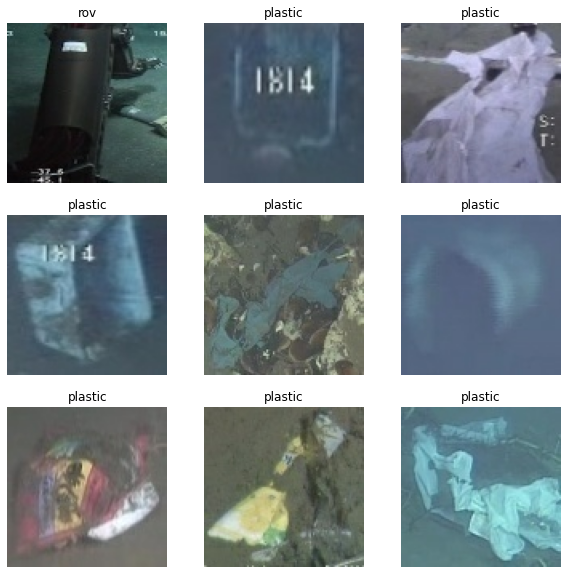

In [ ]:
# Takes in the raw dataset and displays a few images
data_visualization = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  label_mode=LABEL_MODE,
  image_size=(100, 100))

class_names = data_visualization.class_names

plt.figure(figsize=(10, 10))
for images, labels in data_visualization.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Test, Train and Validation Splitting: Base Image Processing
Breaking data into training, testing, and validation sets. Non randomized so output is reproducible, could randomize as an option for exploration after

In [ ]:
# Constants
BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32
NORMALIZED_DATASET_PATH = '/content/drive/MyDrive/Trash Detection/datasets_normalized/'

In [ ]:
# The percentage of the data that will be used for validation and test
# For example indicating .1 in this constant would yield the following splits:
# Train Dataset: 80%
# Test Dataset: 10%
# Validation Dataset: 10%
VALIDATION_TEST_SPLIT = 0.3

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  label_mode=LABEL_MODE,
  validation_split=VALIDATION_TEST_SPLIT,
  shuffle=True,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 9883 files belonging to 10 classes.
Using 6919 files for training.


In [ ]:
print(train_ds.class_names)

['bio', 'cloth', 'fishing', 'metal', 'paper', 'plastic', 'rov', 'rubber', 'unknown', 'wood']


In [ ]:
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  label_mode=LABEL_MODE,
  validation_split=VALIDATION_TEST_SPLIT,
  shuffle=True,
  seed=10,
  subset="validation",
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 9883 files belonging to 10 classes.
Using 2964 files for validation.


In [ ]:
# Creating a test dataset by taking samples from the training dataset
# equivalent to the size of the validation set
val_ds_size = val_ds.cardinality()
test_ds = train_ds.take(val_ds_size)
train_ds = train_ds.skip(val_ds_size)

print(f'Base Image Processing Training Dataset Size: {train_ds.cardinality()} ')
print(f'Base Image Processing Testing Dataset Size: {test_ds.cardinality()} ')
print(f'Base Image Processing Validation Dataset Size: {val_ds.cardinality()} ')

Training Dataset Size: 124 
Testing Dataset Size: 93 
Validation Dataset Size: 93 


In [ ]:
print(train_ds)

<SkipDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# Test, Train and Validation Splitting: Manipulated Images

In [ ]:
# Constants for different types of image manipulation
INVERTED_DATASET_PATH = '/content/drive/MyDrive/Trash Detection/visualization_data/inverted'
CONTRASTED_DATASET_PATH = '/content/drive/MyDrive/Trash Detection/visualization_data/contrasted'
# INV_CONVERTED_DATA_PATH = Planning to do this, but google colab isn't syncing up to drive changes

In [ ]:
inv_train_ds = tf.keras.utils.image_dataset_from_directory(
  INVERTED_DATASET_PATH,
  label_mode=LABEL_MODE,
  validation_split=0.2,
  shuffle=True,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 9883 files belonging to 10 classes.
Using 7907 files for training.


In [ ]:
cntrst_train_ds = tf.keras.utils.image_dataset_from_directory(
  CONTRASTED_DATASET_PATH,
  label_mode=LABEL_MODE,
  validation_split=0.2,
  shuffle=True,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 9883 files belonging to 10 classes.
Using 7907 files for training.


In [ ]:
inv_val_ds = tf.keras.utils.image_dataset_from_directory(
  INVERTED_DATASET_PATH,
  label_mode=LABEL_MODE,
  validation_split=0.2,
  shuffle=True,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 9883 files belonging to 10 classes.
Using 1976 files for validation.


In [ ]:
cntrst_val_ds = tf.keras.utils.image_dataset_from_directory(
  CONTRASTED_DATASET_PATH,
  label_mode=LABEL_MODE,
  validation_split=0.2,
  shuffle=True,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 9883 files belonging to 10 classes.
Using 1976 files for validation.


In [ ]:
inv_val_ds_size = inv_val_ds.cardinality()
inv_test_ds = inv_train_ds.take(inv_val_ds_size)
inv_train_ds = inv_train_ds.skip(inv_val_ds_size)

print(f'Inverted Images Training Dataset Size: {inv_train_ds.cardinality()} ')
print(f'Inverted Images Testing Dataset Size: {inv_test_ds.cardinality()} ')
print(f'Inverted Images Validation Dataset Size: {inv_val_ds.cardinality()} ')

Training Dataset Size: 186 
Testing Dataset Size: 62 
Validation Dataset Size: 62 


In [ ]:
cntrst_val_ds_size = cntrst_val_ds.cardinality()
cntrst_test_ds = cntrst_train_ds.take(cntrst_val_ds_size)
cntrst_train_ds = cntrst_train_ds.skip(cntrst_val_ds_size)

print(f'High Contrast Images Training Dataset Size: {cntrst_train_ds.cardinality()} ')
print(f'High Contrast Images Testing Dataset Size: {cntrst_test_ds.cardinality()} ')
print(f'High Contrast Images Validation Dataset Size: {cntrst_val_ds.cardinality()} ')

Training Dataset Size: 186 
Testing Dataset Size: 62 
Validation Dataset Size: 62 


# Creating the Model
We use a convolutional layer along with a max pooling layer, then a layer to flatten and 1 dense layer before the output layer.
Model params are also specified here (optimizer, loss, metrics, \#epochs)

In [ ]:
# Model Configurations
NUM_EPOCHS = 5
# Optimzers
GRADIENT_DESCENT = 'sgd'
ADAM = 'adam'

# Activation
SIGMOID = 'sigmoid'
RELU = 'relu'
SOFTMAX = 'softmax'

# Loss
BINARY_CROSS = 'binary_crossentropy'

## Label Mode
Label mode selected is based on type of loss.
###See Label Mode:
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

## Convolutional Neural Network


In [ ]:
# Might want to add class weights since we have some very small classes.
modelCNN = keras.Sequential([
                          keras.layers.Conv2D(100, (3,3), input_shape=(IMG_HEIGHT,IMG_WIDTH,3), activation=RELU),
                          keras.layers.MaxPooling2D((2,2)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(IMG_HEIGHT*2, activation=RELU),
                          keras.layers.Dense(units=len(label_counts)),
                          keras.layers.Dense(len(label_counts), activation=SOFTMAX)
])
modelCNN.compile(optimizer=ADAM, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
modelCNN.summary()
modelCNN_history = modelCNN.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS) #, class_weight=test_dict)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 100)       2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 100)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 22500)             0         
                                                                 
 dense (Dense)               (None, 64)                1440064   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                        

93/93 - 5s - loss: 0.5796 - accuracy: 0.8498 - 5s/epoch - 57ms/step


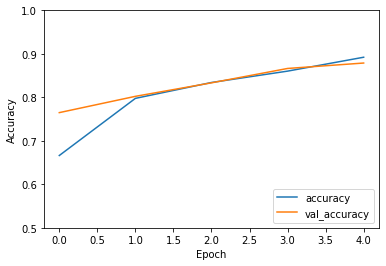

In [ ]:
plt.plot(modelCNN_history.history['accuracy'], label='accuracy')
plt.plot(modelCNN_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelCNN.evaluate(test_ds, verbose=2)

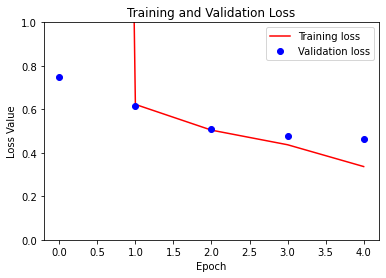

In [ ]:
loss = modelCNN_history.history['loss']
val_loss = modelCNN_history.history['val_loss']

plt.figure()
plt.plot(modelCNN_history.epoch, loss, 'r', label='Training loss')
plt.plot(modelCNN_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## DNN


In [ ]:
modelDNN = keras.Sequential([
                          keras.layers.Reshape(target_shape = (IMG_HEIGHT*IMG_WIDTH*3,), input_shape = (IMG_HEIGHT, IMG_WIDTH,3)),
                          keras.layers.Dense(units= IMG_HEIGHT*8, activation=RELU),
                          keras.layers.Dense(IMG_HEIGHT*2, activation=RELU),
                          keras.layers.Dense(units=len(label_counts))
])
modelDNN.compile(optimizer=ADAM, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
modelDNN.summary()
modelDNN_history = modelDNN.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               786688    
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 803,786
Trainable params: 803,786
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
124/124 [==============================] - 15s 85ms/step - loss: 111.7717 - accuracy: 0.5306 - val_loss: 16.5577 - val_accuracy: 0.5536
Epoch 2/5
124/124 [===============

93/93 - 4s - loss: 2.0854 - accuracy: 0.1455 - 4s/epoch - 48ms/step


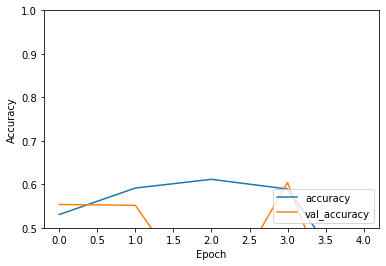

In [ ]:
plt.plot(modelDNN_history.history['accuracy'], label='accuracy')
plt.plot(modelDNN_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelDNN.evaluate(test_ds, verbose=2)

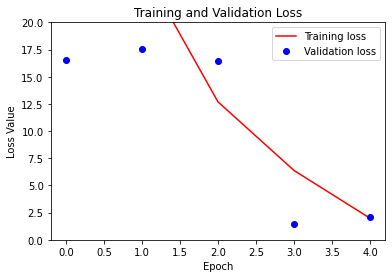

In [ ]:
loss = modelDNN_history.history['loss']
val_loss = modelDNN_history.history['val_loss']

plt.figure()
plt.plot(modelDNN_history.epoch, loss, 'r', label='Training loss')
plt.plot(modelDNN_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 20])
plt.legend()
plt.show()

# Manipulated Images Training and Testing

## Inverted Images


Training

In [ ]:
modelINV = keras.Sequential([
                          keras.layers.Conv2D(100, (3,3), input_shape=(IMG_HEIGHT,IMG_WIDTH,3), activation=RELU),
                          keras.layers.MaxPooling2D((2,2)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(IMG_HEIGHT*2, activation=RELU),
                          keras.layers.Dense(units=len(label_counts)),
                          keras.layers.Dense(len(label_counts),activation='softmax')
])
modelINV.compile(optimizer=ADAM, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
modelINV.summary()
modelINV_history = modelINV.fit(inv_train_ds, validation_data=inv_val_ds, epochs=NUM_EPOCHS)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 100)       2800      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 100)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 22500)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                1440064   
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
 dense_8 (Dense)             (None, 10)                110       
                                                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


186/186 [==============================] - 1004s 4s/step - loss: 8.3127 - accuracy: 0.7138 - val_loss: 0.6211 - val_accuracy: 0.8173
Epoch 2/5
186/186 [==============================] - 23s 106ms/step - loss: 0.4826 - accuracy: 0.8494 - val_loss: 0.5428 - val_accuracy: 0.8446
Epoch 3/5
186/186 [==============================] - 23s 105ms/step - loss: 0.3569 - accuracy: 0.8908 - val_loss: 0.4884 - val_accuracy: 0.8720
Epoch 4/5
186/186 [==============================] - 23s 107ms/step - loss: 0.2792 - accuracy: 0.9124 - val_loss: 0.5413 - val_accuracy: 0.8669
Epoch 5/5
186/186 [==============================] - 23s 106ms/step - loss: 0.2193 - accuracy: 0.9347 - val_loss: 0.5053 - val_accuracy: 0.8725


Plotting Accuracy

93/93 - 5s - loss: 4.0583 - accuracy: 0.3911 - 5s/epoch - 59ms/step


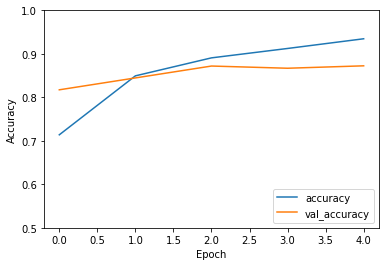

In [ ]:
plt.plot(modelINV_history.history['accuracy'], label='accuracy')
plt.plot(modelINV_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelINV.evaluate(test_ds, verbose=2)

Plotting Loss

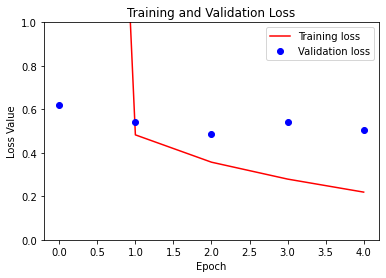

In [ ]:
loss = modelINV_history.history['loss']
val_loss = modelINV_history.history['val_loss']

plt.figure()
plt.plot(modelINV_history.epoch, loss, 'r', label='Training loss')
plt.plot(modelINV_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Contrasted Images

In [ ]:
modelCNTRST = keras.Sequential([
                          keras.layers.Conv2D(100, (3,3), input_shape=(IMG_HEIGHT,IMG_WIDTH,3), activation=RELU),
                          keras.layers.MaxPooling2D((2,2)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(IMG_HEIGHT*2, activation=RELU),
                          keras.layers.Dense(units=len(label_counts)),
                          keras.layers.Dense(len(label_counts), activation='softmax')
])
modelCNTRST.compile(optimizer=ADAM, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
modelCNTRST.summary()
modelCNTRST_history = modelCNTRST.fit(cntrst_train_ds, validation_data=cntrst_val_ds, epochs=NUM_EPOCHS)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 100)       2800      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 100)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 22500)             0         
                                                                 
 dense_9 (Dense)             (None, 64)                1440064   
                                                                 
 dense_10 (Dense)            (None, 10)                650       
                                                                 
 dense_11 (Dense)            (None, 10)                110       
                                                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


186/186 [==============================] - 993s 4s/step - loss: 5.8179 - accuracy: 0.7385 - val_loss: 0.5179 - val_accuracy: 0.8391
Epoch 2/5
186/186 [==============================] - 23s 105ms/step - loss: 0.4031 - accuracy: 0.8867 - val_loss: 0.4051 - val_accuracy: 0.8740
Epoch 3/5
186/186 [==============================] - 23s 106ms/step - loss: 0.2385 - accuracy: 0.9261 - val_loss: 0.4090 - val_accuracy: 0.8871
Epoch 4/5
186/186 [==============================] - 23s 107ms/step - loss: 0.1762 - accuracy: 0.9446 - val_loss: 0.4321 - val_accuracy: 0.8912
Epoch 5/5
186/186 [==============================] - 22s 105ms/step - loss: 0.1109 - accuracy: 0.9657 - val_loss: 0.4380 - val_accuracy: 0.9013


93/93 - 5s - loss: 0.6880 - accuracy: 0.8357 - 5s/epoch - 57ms/step


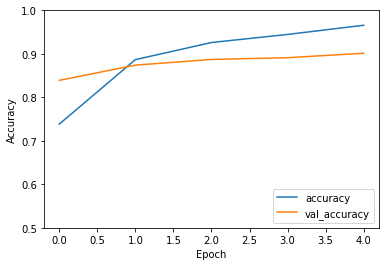

In [ ]:
plt.plot(modelCNTRST_history.history['accuracy'], label='accuracy')
plt.plot(modelCNTRST_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelCNTRST.evaluate(test_ds, verbose=2)

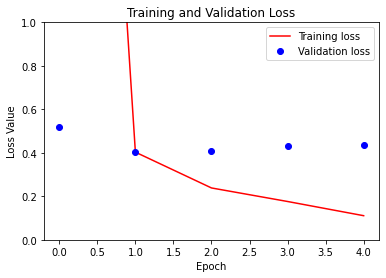

In [ ]:
loss = modelCNTRST_history.history['loss']
val_loss = modelCNTRST_history.history['val_loss']

plt.figure()
plt.plot(modelCNTRST_history.epoch, loss, 'r', label='Training loss')
plt.plot(modelCNTRST_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

#Predict
Use the validation dataset to predict output.

In [ ]:
predictions = np.array([])
labels =  np.array([])

# Performing predictions per batch
for x, y in test_ds:
  for batch in x:
    predictions = np.concatenate([predictions, np.argmax(modelCNN.predict(x), axis=-1)])
    labels = np.concatenate([labels, y.numpy()])

# Checking if all classes made it into the validation set
print(f"Number of predictions made: {len(predictions)}")
print(f"Number of labels included in the predictions {len(labels)}")
print(class_names)

# Converting the predictions and label types form float to unit32
# Intermediate conversion in preperation of associating
# class names with integer labels
predictions = predictions.astype(np.int32)
labels = labels.astype(np.int32)

# Taking a peak into the predictions
print(predictions[:10])
print(labels[:10])

Number of predictions made: 95232
Number of labels included in the predictions 95232
['bio', 'cloth', 'fishing', 'metal', 'paper', 'plastic', 'rov', 'rubber', 'unknown', 'wood']
[5 0 5 5 0 0 6 5 5 5]
[5 0 5 5 0 0 6 5 5 5]


#Evaluation

Confusion Matrix.
Compare statistics such as accuracy and recall (see google doc for our selected statistics.)

https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

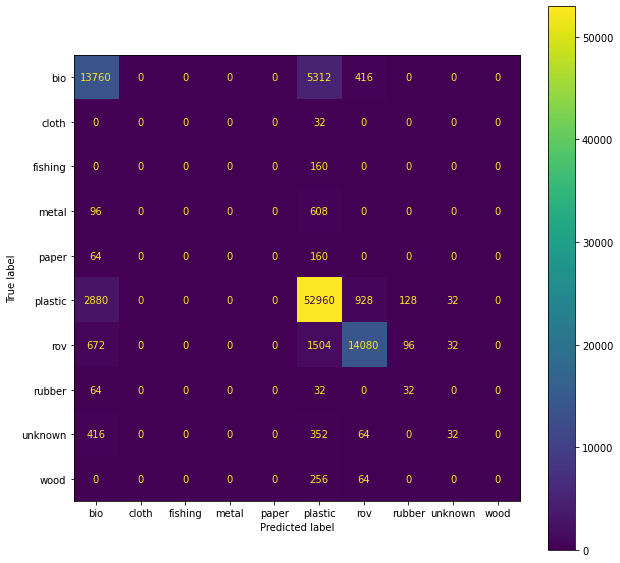

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true=labels, y_pred=predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# Increase the figure size for easy readability of all classes
fig, ax = plt.subplots(figsize=(10,10))

display.plot(ax=ax)
plt.show()